# Initializing config, dataset and the oracle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from dataset import Config, Dataset
from oracle import Oracle
from active_learning import Learner

config = Config(70, 10)
data = Dataset(config)
orac_kl = Oracle(data, config)
orac_ve = Oracle(data, config)
orac_rand = Oracle(data, config)

# Visualizing the digit dataset after PCA

In [4]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=2)
decomposed_digit = pca.fit_transform(X = data.x_raw)

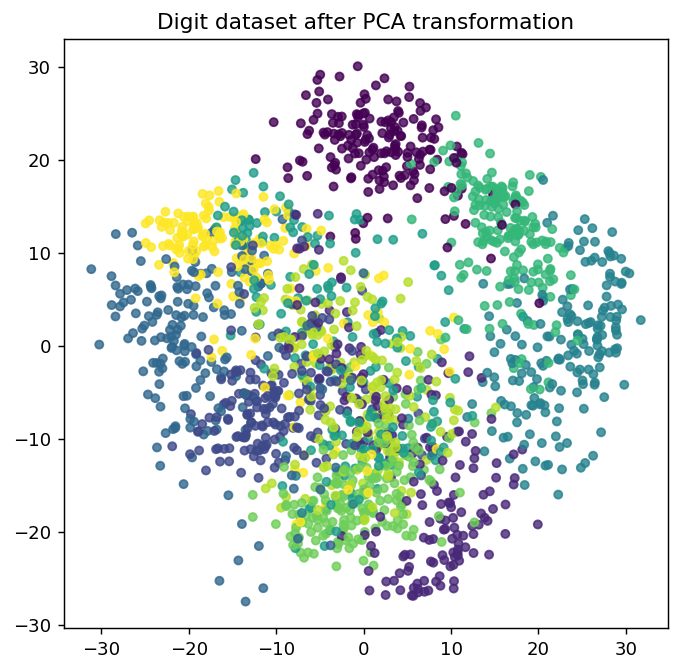

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = decomposed_digit[:, 0], decomposed_digit[:, 1]

test_c1, test_c2 = [], []
for i in range(len(data.test_indices)):
    test_c1.append(x_component[data.test_indices[i]])
    test_c2.append(y_component[data.test_indices[i]])

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(6, 6), dpi=130)
plt.scatter(x = x_component, y = y_component, c = data.y_raw, cmap = 'viridis', s = 20, alpha = 8/10)
plt.title('Digit dataset after PCA transformation')
plt.show()

# Instantiating a Learner instance

In [6]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

clf1 = svm.SVC(gamma=0.001, probability=True)
clf2 = KNeighborsClassifier(n_neighbors = 3)
clf3 = RandomForestClassifier(n_estimators = 10)
clf4 = DecisionTreeClassifier(max_depth=5)
clf5 = GaussianNB()

kl_divergence_learner = Learner([clf1, clf2, clf3, clf4, clf5], "qbc", disagreement = "kl")
vote_entropy_learner = Learner([clf1, clf2, clf3, clf4, clf5], "qbc", disagreement = "ve")
random_learner = Learner([clf1, clf2, clf3, clf4, clf5], "qbc", disagreement = "ve")

# Initial training for the active learners

In [7]:
kl_divergence_learner.train(orac_kl)
vote_entropy_learner.train(orac_ve)
random_learner.train(orac_rand)

In [8]:
initial_pred_kl = kl_divergence_learner.predict(data.test_X)
initial_pred_ve = vote_entropy_learner.predict(data.test_X)
initial_pred_rand = random_learner.predict(data.test_X)

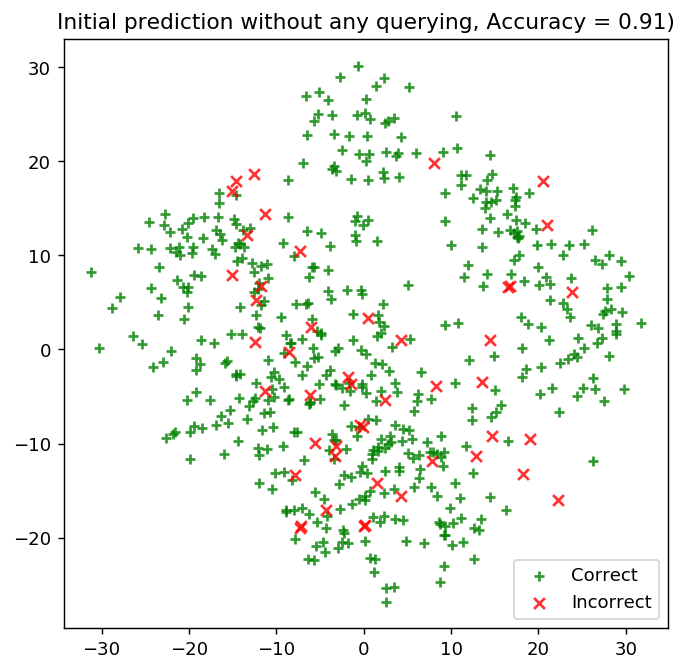

In [9]:
import numpy as np

is_correct = (initial_pred_kl == np.array(data.test_Y))

fig, ax1 = plt.subplots(figsize=(6, 6), dpi=130)
fig.suptitle = "Initial prediction without any querying"

ax1.scatter(x=np.array(test_c1)[is_correct],  y=np.array(test_c2)[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax1.scatter(x=np.array(test_c1)[~is_correct], y=np.array(test_c2)[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax1.legend(loc='lower right')
ax1.set_title("Initial prediction without any querying, Accuracy = {score:.2f})".format(score=kl_divergence_learner.test_score(data)))

plt.show()

# Querying

In [10]:
''' 4 consecutive queries for labelling 10% data in each iteration and evaluating the test performance for 
all the possible informativeness metrics
'''
unqueried_score = kl_divergence_learner.test_score(data)
performance_kl = [unqueried_score]
performance_ve = [unqueried_score]
performance_rand = [unqueried_score]

query_count = 0
while(performance_kl[-1] < 0.95):
    # streaming over the least confidence pool of unlabeled data
    for i in range(len(orac_kl.pool_X)):
        ch = kl_divergence_learner.query(data, orac_kl, stream = i, config = config)
        if(ch == 1):
            query_count = query_count + 1
            kl_divergence_learner.train(orac_kl)
            accuracy = kl_divergence_learner.test_score(data)
            performance_kl.append(accuracy)
            print('Accuracy of least confidence after query {n}: {acc:0.4f}'.format(n=query_count, acc=accuracy))
            if(accuracy >= 0.95):
                break

query_count = 0
while(performance_ve[-1] < 0.95):
    # streaming over the least confidence pool of unlabeled data
    for i in range(len(orac_ve.pool_X)):
        ch = vote_entropy_learner.query(data, orac_ve, stream = i, config = config)
        if(ch == 1):
            query_count = query_count + 1
            vote_entropy_learner.train(orac_ve)
            accuracy = vote_entropy_learner.test_score(data)
            performance_ve.append(accuracy)
            print('Accuracy of margin sample after query {n}: {acc:0.4f}'.format(n=query_count, acc=accuracy))
            if(accuracy >= 0.95):
                break
                
query_count = 0
while(performance_rand[-1] < 0.95):
    # streaming over the least confidence pool of unlabeled data
    for i in range(len(orac_rand.pool_X)):
        ch = random_learner.query(data, orac_rand, stream = i, config = config)
        if(ch == 1):
            query_count = query_count + 1
            random_learner.train(orac_rand)
            accuracy = random_learner.test_score(data)
            performance_rand.append(accuracy)
            print('Accuracy of random sample after query {n}: {acc:0.4f}'.format(n=query_count, acc=accuracy))
            if(accuracy >= 0.95):
                break

Accuracy of least confidence after query 1: 0.9000
Accuracy of least confidence after query 2: 0.9204
Accuracy of least confidence after query 3: 0.9093
Accuracy of least confidence after query 4: 0.9204
Accuracy of least confidence after query 5: 0.9167
Accuracy of least confidence after query 6: 0.9037
Accuracy of least confidence after query 7: 0.9037
Accuracy of least confidence after query 8: 0.9093
Accuracy of least confidence after query 9: 0.9056
Accuracy of least confidence after query 10: 0.9148
Accuracy of least confidence after query 11: 0.9204
Accuracy of least confidence after query 12: 0.9296
Accuracy of least confidence after query 13: 0.9185
Accuracy of least confidence after query 14: 0.9259
Accuracy of least confidence after query 15: 0.9185
Accuracy of least confidence after query 16: 0.9278
Accuracy of least confidence after query 17: 0.9185
Accuracy of least confidence after query 18: 0.9370
Accuracy of least confidence after query 19: 0.9333
Accuracy of least con

# Plotting Improvements with successive querying

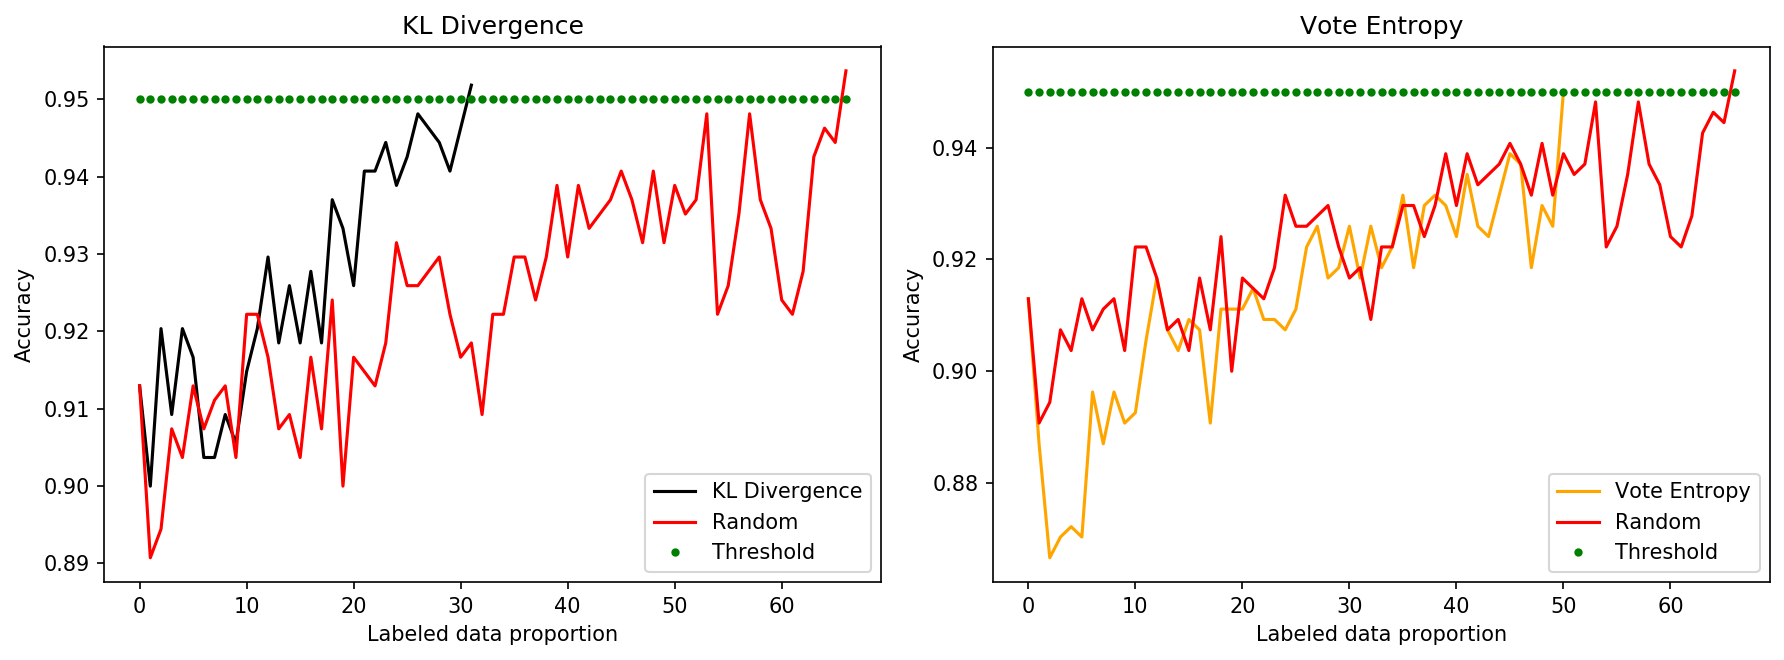

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5), dpi = 150)

cols = ['Least Count', 'Marginal Sampling', 'Entropy']

label_proportion1 = list(range(len(performance_kl)))
label_proportion2 = list(range(len(performance_ve)))
label_proportion3 = list(range(len(performance_rand)))

mx = max(len(performance_kl), len(performance_ve), len(performance_rand))
label_proportion4 = list(range(mx))
dotted = [0.95]*mx

axs[0].plot(label_proportion1, performance_kl, label = "KL Divergence", color='black')
axs[0].plot(label_proportion3, performance_rand, label = "Random", color='red')
axs[0].plot(label_proportion4, dotted, '.', label = "Threshold", color='green')
axs[1].plot(label_proportion2, performance_ve, label = "Vote Entropy", color='orange')
axs[1].plot(label_proportion3, performance_rand, label = "Random", color='red')
axs[1].plot(label_proportion4, dotted, '.', label = "Threshold", color='green')

axs[0].set_title('KL Divergence')
axs[1].set_title('Vote Entropy')

axs[0].set_xlabel('Labeled data proportion')
axs[1].set_xlabel('Labeled data proportion')

axs[0].set_ylabel('Accuracy')
axs[1].set_ylabel('Accuracy')

axs[0].legend(loc='lower right')
axs[1].legend(loc='lower right')

fig.tight_layout()
plt.show()

# Performance after querying

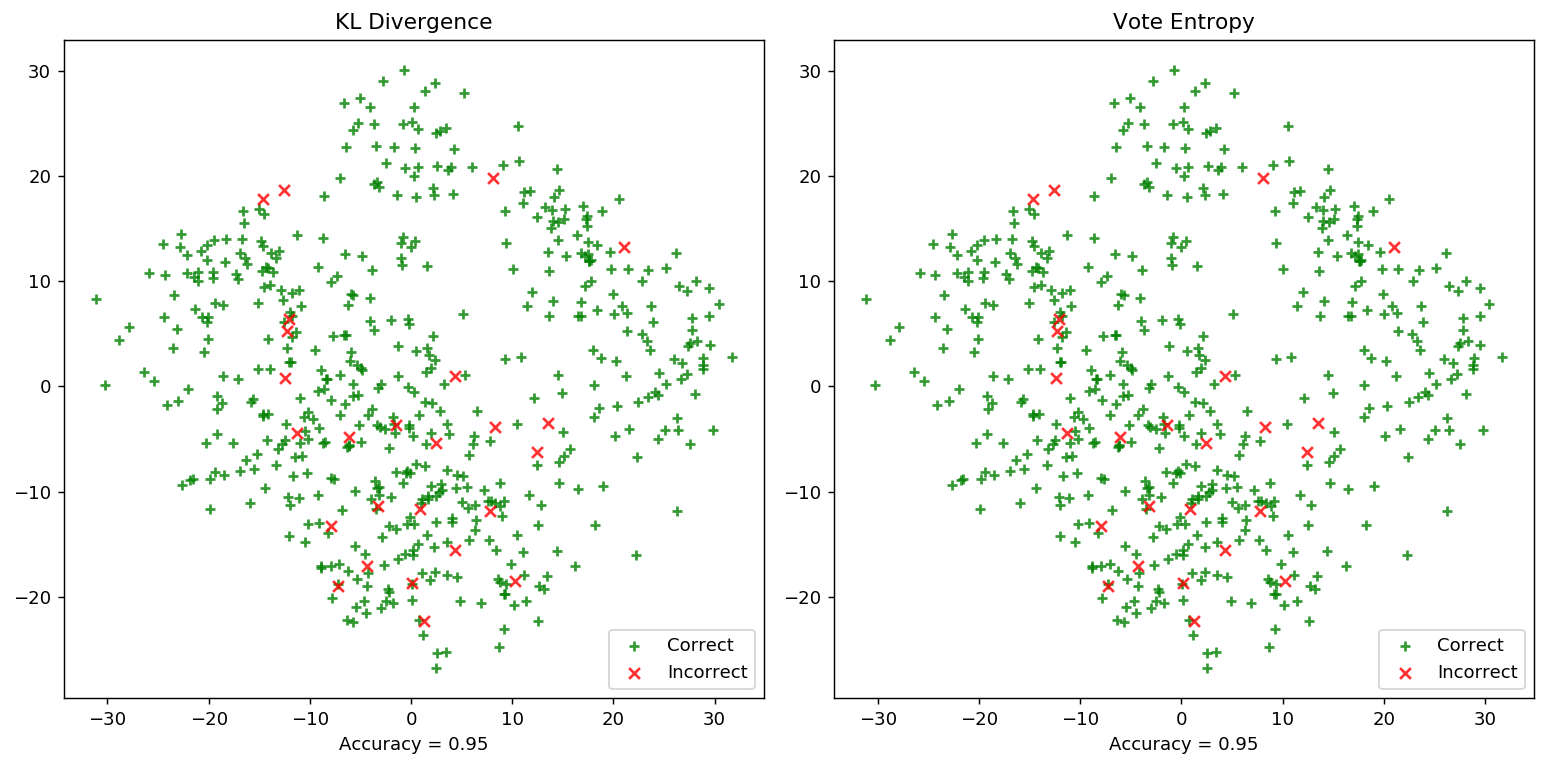

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi = 130)

cols = ['KL Divergence', 'Vote Entropy']
rows = ['After Query {}'.format(row) for row in ['1', '2', '3', '4']]

pred_kl = kl_divergence_learner.predict(data.test_X)
pred_ve = vote_entropy_learner.predict(data.test_X)    
    
is_correct = (pred_kl == np.array(data.test_Y))

axs[0].set_title("KL Divergence")
axs[1].set_title("Vote Entropy")

axs[0].scatter(x=np.array(test_c1)[is_correct],  y=np.array(test_c2)[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
axs[0].scatter(x=np.array(test_c1)[~is_correct], y=np.array(test_c2)[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
axs[0].legend(loc='lower right')
axs[0].set_xlabel("Accuracy = {score:.2f}".format(nq = i-1, score=kl_divergence_learner.test_score(data)))

is_correct = (pred_ve == np.array(data.test_Y))

axs[1].scatter(x=np.array(test_c1)[is_correct],  y=np.array(test_c2)[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
axs[1].scatter(x=np.array(test_c1)[~is_correct], y=np.array(test_c2)[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
axs[1].legend(loc='lower right')
axs[1].set_xlabel("Accuracy = {score:.2f}".format(nq = i-1, score=vote_entropy_learner.test_score(data)))

fig.tight_layout()
plt.show()